In [2]:
#import
import numpy as np
import matplotlib.pyplot as plt
import ot

# for 3d plot
from mpl_toolkits.mplot3d import Axes3D  # noqa
from matplotlib.collections import PolyCollection

# Clustering based on barycenters

## Gaussians

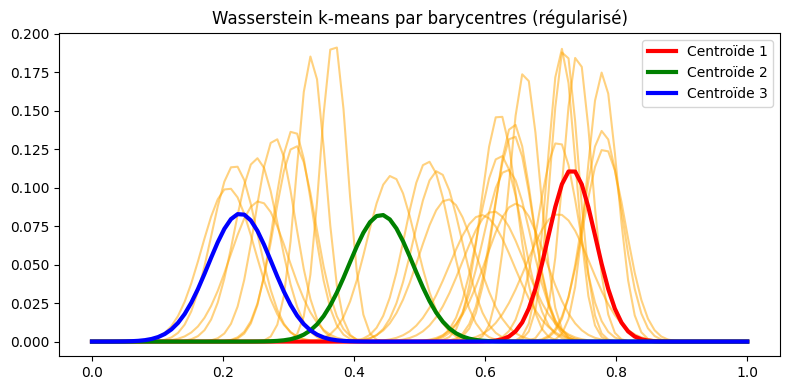

In [ ]:
# parameters

n_distributions = 30 # nombre de probas
n_support = 30 # taille du support des probas
k = 3
reg = 1e-1
n_iter = 20 # nombre d'itérations du k-means

# génération des données
x = np.linspace(0, 1, n_support)  # support commun

def random_gaussian_on_grid():
    m = np.random.uniform(0.2, 0.8)
    s = np.random.uniform(0.02, 0.05)
    density = np.exp(-0.5 * ((x - m) / s)**2)
    return density / density.sum()

distributions = np.array([random_gaussian_on_grid() for _ in range(n_distributions)])

# initialisation des centroides 
indices = np.random.choice(n_distributions, k, replace=False)
centroids = distributions[indices].copy()

# algo
for t in range(n_iter):
    # Affectation : chaque distribution au centroïde le plus proche
    assignments = []
    for i in range(n_distributions):
        dists = [ot.sinkhorn(distributions[i], c, ot.dist(x[:, None], x[:, None]), reg) for c in centroids]
        assignments.append(np.argmin(dists))
    assignments = np.array(assignments)

    # Mise à jour : recalcul des centroïdes comme barycentres de chaque cluster
    new_centroids = []
    for j in range(k):
        members = distributions[assignments == j]
        if len(members) == 0:
            # éviter cluster vide
            new_centroids.append(random_gaussian_on_grid())
        else:
            new_c = ot.bregman.barycenter(members.T, ot.dist(x[:, None], x[:, None]), reg)
            new_centroids.append(new_c)
    centroids = np.array(new_centroids)

# -------------------------
# AFFICHAGE
# -------------------------

colors = ['red', 'green', 'blue', 'purple', 'orange']
plt.figure(figsize=(8, 4))
for i in range(n_distributions):
    plt.plot(x, distributions[i], color=colors[assignments[i] % len(colors)], alpha=0.5)

for j in range(k):
    plt.plot(x, centroids[j], color=colors[j % len(colors)], linewidth=3, label=f'Centroïde {j+1}')

plt.title("Wasserstein k-means par barycentres (régularisé)")
plt.legend()
plt.tight_layout()
plt.show()


## Diracs

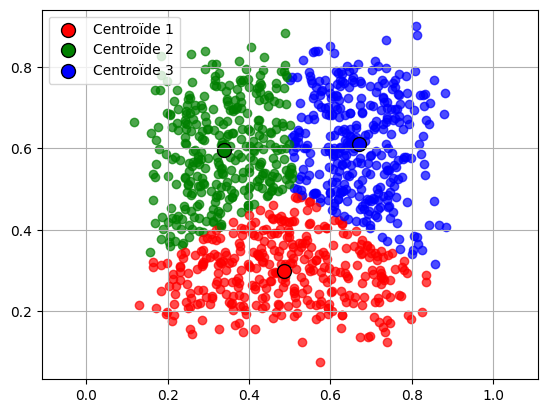

In [19]:
# paramètres
n_distributions = 1000  # nombre de mesures
n_support = 1
reg = 1e-1

# fonction pour générer une mesure (nuage de Diracs) autour d'un centre aléatoire
def random_dirac_measure(n_points):
    center = np.random.uniform(0.2, 0.8, size=2)
    points = np.random.randn(n_points, 2) * 0.05 + center
    return points

# génération des données : chaque "distribution" est un nuage de Diracs (n_support points en R^2)
distributions = [random_dirac_measure(n_support) for _ in range(n_distributions)]
distributions = np.array(distributions, dtype=object)

# initialisation des centroïdes (tirage aléatoire)
indices = np.random.choice(n_distributions, k, replace=False)
centroids = [distributions[i].copy() for i in indices]


# algo
for t in range(n_iter):
    # Affectation du centroide à chaque X_i
    assignments = [] # assignments[i] est l'indice du centroide associé à l'observation i+1 
    for i in range(n_distributions):
        a = np.ones(len(distributions[i])) / len(distributions[i]) #vecteur des poids (comme n_support=1, a=[1])
        dists = []
        for c in centroids:
            b = np.ones(len(c)) / len(c)
            M = np.array(ot.dist(distributions[i], c), dtype=np.float64)
            dists.append(ot.sinkhorn2(a, b, M, reg))
        assignments.append(np.argmin(dists))
    assignments = np.array(assignments)

    # On recalcule les centroides t+1
    new_centroids = []
    for j in range(k):
        members = distributions[assignments == j] #membres du cluster j
        if len(members) == 0:
            # éviter cluster vide
            new_centroids.append(random_dirac_measure(n_support))
        else:
            weights = np.ones(len(members)) / len(members) #poids DANS le cluster 
            measures_weights = [np.ones(len(m)) / len(m) for m in members] # poids internes à chaque mesure
            X_init = np.mean(np.stack(members), axis=0) # nécessaire pour la fonction suivante (mais on fait une dist eucli ...)

            new_c = ot.lp.free_support_barycenter(members, measures_weights, X_init, weights=weights)


            new_centroids.append(new_c)
    centroids = np.array(new_centroids)

# affichage
colors = ['red', 'green', 'blue', 'purple', 'orange']

for i in range(n_distributions):
    plt.scatter(distributions[i][:, 0], distributions[i][:, 1], alpha=0.7, color=colors[assignments[i] % k])

for j, c in enumerate(centroids):
    plt.scatter(c[:, 0], c[:, 1], color=colors[j % k], edgecolor='black', s=100, label=f"Centroïde {j+1}")

plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

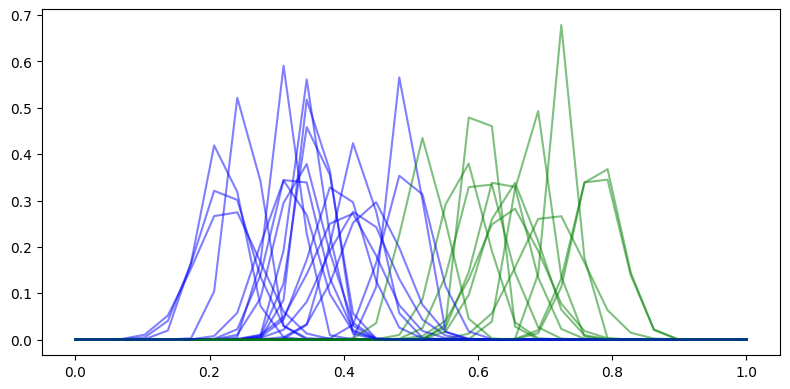

In [4]:
# paramètres
n_distributions = 30
n_support = 30
k = 3
reg = 1e-3
n_iter = 10

# données
x = np.linspace(0, 1, n_support)

def random_gaussian_on_grid():
    m = np.random.uniform(0.2, 0.8)
    s = np.random.uniform(0.02, 0.05)
    density = np.exp(-0.5 * ((x - m) / s)**2)
    return density / density.sum()

distributions = np.array([random_gaussian_on_grid() for _ in range(n_distributions)])

# initialisation des clusters
assignments = np.random.choice(k, size=n_distributions)

# coût
M = ot.dist(x[:, None], x[:, None])  # distance W1
# M = ot.dist(x[:, None], x[:, None]) ** 2  # distance W2^2

# algo
for _ in range(n_iter):
    new_assignments = np.zeros(n_distributions, dtype=int)
    for i in range(n_distributions):
        avg_dists = []
        for j in range(k):
            members = np.where(assignments == j)[0]
            if len(members) == 0:
                avg_dists.append(np.inf)
            else:
                dists = [ot.sinkhorn2(distributions[i], distributions[m], M, reg) for m in members]
                avg_dists.append(np.mean(dists))
        new_assignments[i] = np.argmin(avg_dists)
    if np.array_equal(assignments, new_assignments):
        break
    assignments = new_assignments

# affichage
colors = ['red', 'green', 'blue', 'purple', 'orange']
plt.figure(figsize=(8, 4))
for i in range(n_distributions):
    plt.plot(x, distributions[i], color=colors[assignments[i] % len(colors)], alpha=0.5)

plt.tight_layout()
plt.show()


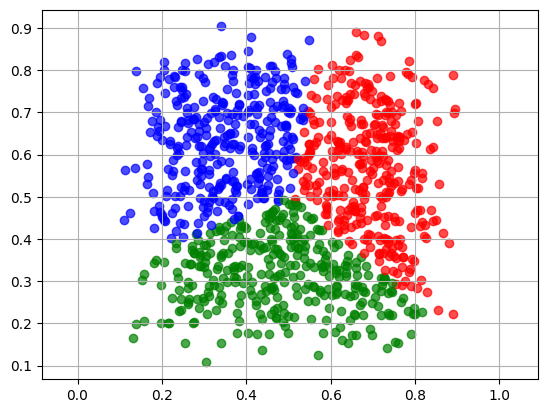

In [3]:
# paramètres
n_distributions = 1000
n_support = 1
k = 3
reg = 1e-1
n_iter = 20

# données
def random_dirac_measure(n_points):
    center = np.random.uniform(0.2, 0.8, size=2)
    points = np.random.randn(n_points, 2) * 0.05 + center
    return points

distributions = [random_dirac_measure(n_support) for _ in range(n_distributions)]
distributions = np.array(distributions, dtype=object)

# initialisation des G_i
assignments = np.random.choice(k, size=n_distributions)

# algo
for _ in range(n_iter):
    new_assignments = np.zeros(n_distributions, dtype=int)

    for i in range(n_distributions):
        a = np.ones(len(distributions[i])) / len(distributions[i])
        avg_dists = []
        for j in range(k):
            members = np.where(assignments == j)[0]
            if len(members) == 0:
                avg_dists.append(np.inf)
            else:
                dists = []
                for m in members:
                    b = np.ones(len(distributions[m])) / len(distributions[m])
                    M = np.array(ot.dist(distributions[i], distributions[m]), dtype=np.float64)
                    dists.append(ot.sinkhorn2(a, b, M, reg))
                avg_dists.append(np.mean(dists))
        new_assignments[i] = np.argmin(avg_dists)

    if np.array_equal(assignments, new_assignments):
        break
    assignments = new_assignments

# plot
colors = ['red', 'green', 'blue', 'purple', 'orange']
for i in range(n_distributions):
    plt.scatter(distributions[i][:, 0], distributions[i][:, 1], alpha=0.7, color=colors[assignments[i] % k])

plt.axis("equal")
plt.grid(True)
plt.show()
